In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorf

loading dataset

In [2]:
path = './data/'
doc = np.load(path+'word_vec.npy', allow_pickle=True)
df = df = pd.read_csv(path+'nm_review(score_balanced).tsv', delimiter='\t', index_col=0)

In [3]:
print(f'doc.shape: {doc.shape}')
print(f'df.shape: {df.shape}')
print(f'len(doc[0]): {len(doc[0])}')
print(f'df.columns: {df.columns}')

doc.shape: (86750,)
df.shape: (86750, 7)
len(doc[0]): 8
df.columns: Index(['code', 'uid', 'datetime', 'score', 'review', 'sympathy',
       'notsympathy'],
      dtype='object')


setting random seed

In [4]:
# 랜덤시드 설정
import random
seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
tf.set_random_seed(seed_value)

splitting dataset

In [5]:
from sklearn.model_selection import train_test_split

# train : test = 8 : 2
x_train, x_test, y_train, y_test = train_test_split(doc, df['score'], test_size=0.2, shuffle=True, stratify=df['score'])

print(f'x_train.shape: {x_train.shape}')
print(f'x_test.shape : {x_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape : {y_test.shape}')

x_train.shape: (69400,)
x_test.shape : (17350,)
y_train.shape: (69400,)
y_test.shape : (17350,)


feature sequence processing

In [6]:
maxlen = max([len(x) for x in doc])

In [7]:
from keras.preprocessing import sequence

print('Pad sequences (samples x time)')
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen, dtype='float32', padding='post')
x_test_seq = sequence.pad_sequences(x_test, maxlen=maxlen, dtype='float32', padding='post')
print('x_train_seq shape:', x_train_seq.shape)
print('x_test_seq shape:', x_test_seq.shape)

Pad sequences (samples x time)
x_train_seq shape: (69400, 60, 128)
x_test_seq shape: (17350, 60, 128)


feature scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])
for idx, item in enumerate(x_train_seq):
    x_train_seq[idx] = mms.transform(item)
for idx, item in enumerate(x_test_seq):
    x_test_seq[idx] = mms.transform(item)

label encoding

In [9]:
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((1e-6, 1-(1e-6)))
mms.fit([[1], [10]])
y_train_mms = mms.transform(np.array(y_train).reshape(-1, 1))
y_test_mms = mms.transform(np.array(y_test).reshape(-1, 1))
# 복구할땐 mms.inverse_transform(y_test_mms)[0]

RNN modeling

In [10]:
from __future__ import print_function

from keras import layers
from keras import models
from keras import regularizers
from keras.layers import LSTM, Bidirectional, Dense, Dropout

In [11]:
def conv_block(x, filter_nums, filter_sizes):
    """A convolution block"""
    conv_blocks = []

    for fn, fs in zip(filter_nums, filter_sizes):
        conv = layers.Conv1D(filters=fn,
                             kernel_size=fs,
                             padding='same',
                             activation='relu',
                             strides=1)(x)
        #conv = layers.GlobalMaxPooling1D()(conv)
        conv_blocks.append(conv)

    return conv_blocks

In [42]:
def create_model():
    inputs = layers.Input(shape=(60, 128))
    
    # CNN
    blocks = conv_block(inputs, 
                        filter_nums=(64, 64, 64, 64), 
                        filter_sizes=(1, 2, 3, 4))
    cnn_outputs = layers.Concatenate()(blocks)
    cnn_outputs = Dropout(0.3)(cnn_outputs)
    
    # Bi-LSTM
    lstm_outputs = Bidirectional(
        LSTM(64,
             dropout=0.3,
             recurrent_activation='relu',
             recurrent_initializer='glorot_uniform'))(cnn_outputs)
    
    # outputs
    outputs = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(lstm_outputs)
    outputs = Dropout(0.2, seed=42)(outputs)
    outputs = Dense(1, kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.04))(outputs)
        
    model = models.Model(inputs, outputs)

    return model


In [43]:
model = create_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60, 128)      0                                            
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 60, 64)       8256        input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 60, 64)       16448       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 60, 64)       24640       input_3[0][0]                    
____________________________________________________________________________________________

In [44]:
# losses and optimizer
from keras import backend as K
from keras import optimizers

def custom_loss(y_true, y_pred):
    return K.sum(K.square(y_true - y_pred))

def custom_mae(y_true, y_pred):
    loss = tf.keras.losses.MAE(
        K.sum(y_true*tf.constant(list(range(1, 11)), dtype=tf.float32), axis=1),
        K.sum(y_pred*tf.constant(list(range(1, 11)), dtype=tf.float32), axis=1)
    )
    return loss

Adam = optimizers.Adam(learning_rate=0.001, clipnorm=0.5)
RMSprop = optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipnorm=0.5)

In [45]:
# model compile
model.compile(optimizer=RMSprop, loss='mse', metrics=['mae'])

In [46]:
# early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [47]:
# checkpoint
cp = keras.callbacks.ModelCheckpoint(
    './model/ckpt/cnn_bilstm_reg.ckpt', monitor='val_loss', save_best_only=True, save_weights_only=True)

In [48]:
# learn
history = model.fit(x_train_seq, y_train_mms, batch_size=256, epochs=1000, validation_split=0.2, shuffle=True,
                    callbacks=[es, cp])

Train on 55520 samples, validate on 13880 samples
Epoch 1/1000
55520/55520 [==============================] - 35s 623us/step - loss: 0.1090 - mae: 0.2373 - val_loss: 0.0709 - val_mae: 0.2064
Epoch 2/1000
55520/55520 [==============================] - 35s 624us/step - loss: 0.0725 - mae: 0.2130 - val_loss: 0.0648 - val_mae: 0.2022
Epoch 3/1000
55520/55520 [==============================] - 43s 768us/step - loss: 0.0675 - mae: 0.2066 - val_loss: 0.0636 - val_mae: 0.1962
Epoch 4/1000
55520/55520 [==============================] - 60s 1ms/step - loss: 0.0647 - mae: 0.2018 - val_loss: 0.0614 - val_mae: 0.1972
Epoch 5/1000
55520/55520 [==============================] - 45s 808us/step - loss: 0.0630 - mae: 0.1986 - val_loss: 0.0588 - val_mae: 0.1922
Epoch 6/1000
55520/55520 [==============================] - 34s 613us/step - loss: 0.0614 - mae: 0.1960 - val_loss: 0.0587 - val_mae: 0.1864
Epoch 7/1000
55520/55520 [==============================] - 33s 592us/step - loss: 0.0597 - mae: 0.1927 - 

55520/55520 [==============================] - 33s 591us/step - loss: 0.0397 - mae: 0.1541 - val_loss: 0.0553 - val_mae: 0.1767
Epoch 59/1000
55520/55520 [==============================] - 35s 627us/step - loss: 0.0396 - mae: 0.1539 - val_loss: 0.0559 - val_mae: 0.1802
Epoch 00059: early stopping


In [52]:
# checkpoint load
model.load_weights('./model/ckpt/cnn_bilstm_reg.ckpt')

In [53]:
# 모델 평가
results = model.evaluate(x_test_seq, y_test_mms)
print('loss: {:.6f} - mae: {:.6f}'.format(*results))

17350/17350 [==============================] - 33s 2ms/step
loss: 0.054766 - mae: 0.181677


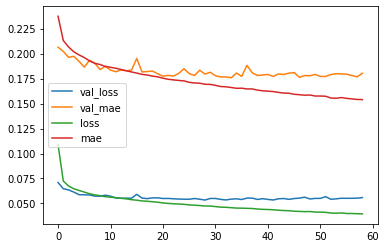

In [50]:
import matplotlib.pyplot as plt
for name, value in history.history.items():
    plt.plot(value, label=name)

plt.legend()
plt.show()

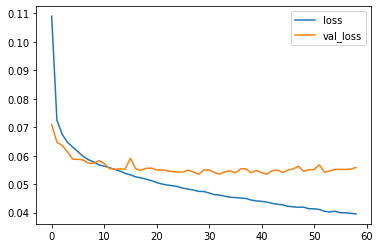

In [51]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

predicting

In [55]:
import numpy as np
from gensim.models import FastText

ft_model = FastText.load('./model/fasttext_model')

In [56]:
from hg_encoder import encode

def get_vector(query):
    query_ = encode(query)
    wv = ft_model.wv.get_vector(query_)
    return wv

In [69]:
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler

# min-max scaler
mms = MinMaxScaler((-1, 1))
mms.fit([[-20.5], [20.5]])

text = '인생작 중 하나입니다.'
wvs = np.array([get_vector(t) for t in text.split(' ')])
wvs = mms.transform(wvs)
wvs_seq = sequence.pad_sequences(wvs.reshape(1, wvs.shape[0], -1), maxlen=60, dtype='float32', padding='post')

In [70]:
# predict
mms = MinMaxScaler((1e-6, 1-(1e-6)))
mms.fit([[1], [10]])
print('predict score: {}'.format(mms.inverse_transform(model.predict(wvs_seq))))

predict score: [[6.378504]]


saving & loading model

In [54]:
# save model
model.save_weights('./model/cnn_bilstm_reg')

In [92]:
# load model
model.load_weights('./model/cnn_bilstm_reg')

평점 예측기 모듈화

In [93]:
from lstm_predictor import predict, argmax_score, weighted_sum_score
text = '인생작 중 하나입니다.'
print(predict(text))
print(argmax_score(text))
print(weighted_sum_score(text))

ValueError: Error when checking input: expected sequential_1_input to have shape (60, 100) but got array with shape (60, 128)

In [10]:
text = '이거 망작임... 노잼..'
print(predict(text))
print(argmax_score(text))
print(weighted_sum_score(text))

[[2.5813854e-01 2.9679337e-01 1.4852859e-01 1.8646912e-01 9.0049468e-02
  1.6015867e-02 2.2455275e-03 6.0565042e-04 2.6135668e-04 8.9249172e-04]]
2
2.6213711071468424


In [12]:
text = '가볍게 보기엔 괜찮은듯'
print(predict(text))
print(argmax_score(text))
print(weighted_sum_score(text))

[[0.0012155  0.00216439 0.00466361 0.01581859 0.04261071 0.23804
  0.29359055 0.35419318 0.03591179 0.01179175]]
8
7.053905818378553


In [1]:
from lstm_predictor import predict, argmax_score, weighted_sum_score
text = '재미있다.'
print(predict(text))
print(argmax_score(text))
print(weighted_sum_score(text))

Using TensorFlow backend.
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\h2oin\Anaconda3\envs\nlp_env1


[[0.01267976 0.01497829 0.01648094 0.01918556 0.03550761 0.04612334
  0.10272116 0.2316486  0.33790433 0.18277045]]
9
8.064179816283286
